# Library

In [241]:
import numpy as np
import pandas as pd
import random
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn                               # layers
import torch.nn.functional as F
import torch.optim as optim                         # optimizer
import torchvision.datasets as ds                   # mnist daataset
import torchvision.transforms as transforms         # image -> tensor
from torch.utils.data import DataLoader, Dataset    # torch dataset

import matplotlib.pyplot as plt                     # 시각화
import seaborn as sns
import plotly.express as px

# Multi-Layer Pereceptron (MLP)

## MLP란?
퍼셉트론으로 이루어진 층(layer) 여러 개를 순차적으로 붙여놓은 형태

<br>

<font style="font-size:20px"> 등장 배경 </font> <p>
<font style="font-size:16px"> XOR 게이트 문제 </font> <p>
&nbsp;&nbsp;&nbsp;&nbsp;and나 or의 경우 직선 하나로 경계를 확정할 수 있으나 xor에서는 불가 <br>

  ![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FNalwG%2FbtqxdrzsQAV%2FUY3iSEDRakKDjoWEpRHRWk%2Fimg.png)

<br>

<font style="font-size:20px"> 구조 </font> <p>

<img src="https://ars.els-cdn.com/content/image/1-s2.0-S0925231223004502-gr1.jpg" width="700" height="300"/>

단순 matrix 연산의 반복 <br>
> A1 = $\textbf{W}_1X + \textbf{b}_1$ <br>
> h1 = $\phi_1$(A1) <br>
> A2 = $\textbf{W}_2\text{h1} + \textbf{b}_2 = \textbf{W}_2\phi_1(\textbf{W}_1X + \textbf{b}_1) + \textbf{b}_2$ <br>
> h2 = $\phi_2$(A2) = $ \phi(\textbf{W}_2\phi_1(\textbf{W}_1X + \textbf{b}_1) + \textbf{b}_2) $
> ...

<br>

Hidden Layer의 $\phi$는 activation 함수는 비선형을 목적으로 사용 <br>




## 사용 방법

### GPU 사용 확인

시스템에서 gpu를 사용할 수 있는지 확인

<br>

<font style="font-size:20px"> 사용 예제 </font> <p>

> ```python
> device = 'cuda' if torch.cuda.is_available() else 'cpu'
> ```

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Seed 고정

실험 재현을 위한 난수 고정

<br>

<font style="font-size:20px"> 사용 예제 </font> <p>

> ```python
> seed = 0
> np.random.seed(seed)
> torch.manual_seed(seed)
> if device == 'cuda':
>     torch.cuda.manual_seed(seed)
>     torch.cuda.manual_seed_all(seed)
>     torch.backends.cudnn.deterministic = False
>     torch.backends.cudnn.benchmark = True
> ```

In [11]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

### 하이퍼파라미터 설정

하이퍼파라미터: 모델에서 학습되지 않는 사용자가 직접 설정해야하는 파라미터 <br>
대표적으로는 아래의 파라미터 존재 <br>
- batch_size: 전체 데이터 중 데이터를 묶음으로 분할할 건데 몇 개의 묶음으로 분할할지 설정
- epoch: 몇 번의 학습을 진행할 것인가
- learning_rate: 얼마 만큼의 보폭으로 학습을 진행할 것인가


In [140]:
batch_size = 32
epochs = 100
learning_rate = 1e-2

### 데이터 전처리

In [15]:
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j

    return X, Y

In [41]:
X, y = load_planar_dataset()

#### 결측치 중복 처리

In [21]:
data = pd.DataFrame(X, columns=['x1', 'x2'])
data['y'] = y
print(f'num of na: {data.isna().sum()}')
print(f'num of duplicated: {data.duplicated().sum()}')

num of na: x1    0
x2    0
y     0
dtype: int64
num of duplicated: 0


#### train, valid, test split

<img src="https://camo.githubusercontent.com/109b64cb7b6e1b6d912b84a1b6afefa53300033be1df4ed8c4433910f8c328bf/68747470733a2f2f76656c6f672e76656c63646e2e636f6d2f696d616765732f696775762f706f73742f38616538343265332d663262362d343463352d623762662d6131663734623361393132342f696d6167652e706e67" width="500" height="300"/>

<br>
<br>

<font style="font-size:20px"> 사용 예제 </font> <p>

> ```python
> X_train, X_temp, y_train, y_temp = train_test_split(
>     X, y, test_size=0.6, random_state=seed, shuffle=True)
> X_valid, X_test, y_valid, y_test = train_test_split(
>     X, y, test_size=0.5, random_state=seed, shuffle=True)
> ```

In [42]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=seed
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=seed
)

In [30]:
len(X_train), len(X_valid), len(X_test)

(240, 80, 80)

#### scaler 적용

일반화 성능을 위해 scaler 적용

<br>

<font style="font-size:20px"> 사용 예제 </font> <p>

> ```python
> standard_scaler = StandardScaler()
> X_train = standard_scaler.fit_transform(X_train)
> X_valid = standard_scaler.fit(X_valid)
> X_test = standard_scaler.fit(X_test)
> ```

In [43]:
standard_scaler_x = StandardScaler()
X_train = standard_scaler_x.fit_transform(X_train)
X_valid = standard_scaler_x.transform(X_valid)
X_test = standard_scaler_x.transform(X_test)

### Dataset

DataLoader에서 불러올 데이터의 형식을 지정하는 클래스. <br>
\_\_getitem\_\_의 idx는 전체 데이터의 인덱스를 임의로 추출. <br>
&nbsp;&nbsp;&nbsp;&nbsp;-> def \_\_len\_\_(self)에서 정의된 데이터의 크기를 사용하기에 **반드시 정의**하여야 함. <br>
**Dataset class를 상속**받아 구현

<br>

<font style="font-size:20px"> 사용 예제 </font> <p>

> ```python
> class CustomDataset(Dataset):
>     def __init__(self, x, y, ...):
>         super().__init__()
>         self.x = x
>         self.y = y
> 
>     def __len__(self):
>         return len(self.x)
> 
>     def __getitem__(self, idx):
>         x = self.x[idx]
>         y = self.y[idx]
> 
>         x = torch.Tensor(x)
>         y = torch.Tensor(y)
>         
>         return x, y
> ```

In [106]:
class PlanarDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = torch.from_numpy(self.X[idx]).float()
        y = torch.from_numpy(self.y[idx]).float()

        return X, y

In [129]:
train_dataset = PlanarDataset(X_train, y_train)
valid_dataset = PlanarDataset(X_valid, y_valid)
test_dataset = PlanarDataset(X_test, y_test)

In [51]:
train_dataset[0]

(tensor([1.5398, 0.8657], dtype=torch.float64), tensor([1], dtype=torch.uint8))

### DataLoader

데이터셋을 순회(iterate)할 때 사용. <br>
각 순회(iteration)는 batch_size의 특징(feature)과 정답(label)의 묶음(batch)을 반환. <br>

<br>

<font style="font-size:20px"> 사용 예제 </font> <p>

> ```python
> train_dataloader = DataLoader(
>     dataset=train_dataset,
>     batch_size=batch_size,
>     shuffle=False,
>     drop_last=True,
> )
> 
> valid_dataloader = DataLoader(
>     dataset=valid_dataset,
>     batch_size=batch_size,
>     shuffle=False,
>     drop_last=True,
> )
> 
> test_dataloader = DataLoader(
>     dataset=test_dataset,
>     batch_size=batch_size,
>     shuffle=False,
>     drop_last=True,
> )
> ```

In [130]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
)

In [109]:
X, y = list(train_dataloader)[0]

In [85]:
X.shape

torch.Size([32, 2])

In [86]:
y.shape

torch.Size([32, 1])

### 모델 구조 정의

학습 시 사용할 모델 아키텍처 정의. <br>
- 모형 복잡도에 비해 데이터 수가 적으면 오버피팅 발생 가능성 높음
- 모형 복잡도에 비해 데이터 수가 많으면 언더피팅 발생 가능성 높음 <br>

**nn.Module을 상속받아 구현.** <br>
생성자에서는 사용할 layer 정의 <br>
forward 함수는 순전파 구현 <br>

<br>

<font style="font-size:20px"> 사용 예제 </font> <p>

> ```python
> class MLP(nn.Module):
>     def __init__(self, input_dim, hidden_dim, output_dim):
>       super(MLP, self).__init__()
>       self.fc1 = nn.Linear(input_dim, hidden_dim)   # input_dim: feature 수, hidden_dim: 중간에 사용될 뉴런의 수
>       self.relu = nn.ReLU()                         # ReLU: activation function
>       self.fc2 = nn.Linear(hidden_dim, output_dim)  # output_dim: target의 수
> 
>     def forward(self, x):
>       x = self.fc1(x)       # input layer -> hidden layer
>       x = self.relu(x)      # hidden layer -> activation fuction
>       x = self.fc2(x)       # activation function -> output layer
> 
>       return x
> ```

In [142]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        x = self.linear2(x)
        x = self.sigmoid(x)

        return x

### 모델 선언

In [117]:
mlp = MLP(2, 4, 1).to(device)

In [110]:
mlp(X)

tensor([[0.5482],
        [0.5851],
        [0.5564],
        [0.5521],
        [0.5553],
        [0.5512],
        [0.5865],
        [0.5318],
        [0.5566],
        [0.5548],
        [0.5591],
        [0.5360],
        [0.5530],
        [0.5376],
        [0.5497],
        [0.5481],
        [0.5536],
        [0.5625],
        [0.5371],
        [0.5444],
        [0.5578],
        [0.5507],
        [0.5316],
        [0.5483],
        [0.5568],
        [0.5349],
        [0.5477],
        [0.5849],
        [0.5539],
        [0.5478],
        [0.5481],
        [0.5534]], grad_fn=<SigmoidBackward0>)

### Loss, Optimizer 정의

학습 시 사용할 loss와 optimizer 명시
- loss: 정답과 모델 예측 값의 차이 계산
- optimizer: parameter를 update할 로직 설정


<br>

<font style="font-size:20px"> 사용 예제 </font> <p>

> ```python
> criterion = nn.CrossEntropyLoss().to(device)
> optimizer = optim.Adam(model.parameters(), lr=learning_rate)
> ```

In [138]:
criterion = nn.BCELoss().to(device)
optimizer = optim.Adam(mlp.parameters(), learning_rate)

### Train & Validation

<font style="font-size:20px"> Train </font> <p>
정의된 loss와 optimizer를 통해 학습 진행. <br>
모델이 주어진 데이터에서만 잘 동작하는 것(overfitting)을 주의해야 함. <br>

<br>

<font style="font-size:20px"> Validation </font> <p>
학습 중인 모델의 성능을 평가하기 위한 데이터. <br>
학습 데이터에 포함되어 있지 않기에 학습 시 validation data의 패턴을 학습하지는 않으나 <br>
학습되지 않는 데이터를 통해 현재 학습되는 모델의 성능을 평가 <br>
오버피팅을 확인하는 목적으로 주로 사용 <br>

<br>

**오버피팅** <br>

<img src="https://camo.githubusercontent.com/32695ae0709af770e85679280d75b1d377a43eac73cece31c1b03290ed8cd911/68747470733a2f2f696d67312e6461756d63646e2e6e65742f7468756d622f523132383078302f3f73636f64653d6d746973746f72793226666e616d653d6874747073253341253246253246626c6f672e6b616b616f63646e2e6e6574253246646e2532466f73304535253246627471456d6f5168385a36253246745532756e6636426e464e6d776234597873736f696b253246696d672e706e67" width="500" height="300"/>

주어진 데이터에 모델이 높은 결과를 내도록 적합되는 것 <br>
이 경우 일반화 성능이 떨어지기에 오버피팅은 딥러닝 학습에서 중요한 이슈 <br>

<br>

<font style="font-size:20px"> 사용 예제 </font> <p>

> ```python
> train_losses = []
> train_accs = []
> valid_losses = []
> valid_accs = []
> for epoch in tqdm(range(1, epochs+1)):      # 학습 횟수 설정
>     total_train_loss = 0
>     total_train_acc = 0
> 
>     model.train()                           # dropout, batch norm 등 train과 train이 아닌 경우의 동작이 다를 때 학습 시 적용
>     for X, y in train_loader:
>         X = X.reshape(batch_size, -1).to(device)
>         y = y.to(device)
> 
>         optimizer.zero_grad()               # optimizer의 parameter에 대한 gradient 초기화
>         y_pred = model(X)                   # model 예측값 계산 (순전파)
>         train_loss = criterion(y_pred, y)   # model 예측값과 실제 값과의 loss 계산
>         train_loss.backward()               # 계산된 loss를 바탕으로 각 parameter에 대한 기울기 계산
>         optimizer.step()                    # 계산한 기울기를 바탕으로 parameter update
>
>         total_train_loss += train_loss
>         total_train_acc += (y == result.argmax(axis=-1)).sum()
>     
>     mean_test_loss = total_test_loss / len(test_loader)
>     mean_test_acc = total_test_acc / len(test_loader)
>     train_losses.append(total_train_loss)
>     train_accs.append(total_train_acc)
> 
>     model.eval()                            # dropout, batch norm 등 train과 train이 아닌 경우의 동작이 다를 때 학습이 아닐 시 적용
>     with torch.no_grad:                     # 가중치 업데이트를 진행하지 않기에 gradient 제거
>         for X, y in valid_loader:
>             X = X.reshape(batch_size, -1).to(device)
>             y = y.to(device)
> 
>             y_pred = model(X)                
>             valid_loss = criterion(y_pred, y)
> 
>             total_valid_loss += valid_loss
>             total_valid_acc += (y == result.argmax(axis=-1)).sum()
> 
>         mean_valid_loss = total_valid_loss / len(valid_loader)
>         mean_valid_acc = total_valid_acc / len(valid_loader)
>         valid_losses.append(mean_valid_loss)
>         valid_accs.append(mean_valid_acc)
>         
>     print(f'Epoch: {epoch: 3d} | train_loss: {mean_train_loss: .6f} | train_acc = {mean_train_acc: .2f}% | valid_loss: {mean_valid_loss: .6f} | valid_acc = {mean_valid_acc: .2f}%')
```

In [115]:
len(list(train_dataloader)[0])

[tensor([[ 0.1235, -0.7493],
         [ 2.0218, -0.7239],
         [ 0.6409, -1.7714],
         [ 0.9353, -1.5894],
         [ 1.5733, -0.8141],
         [ 0.7955, -1.7908],
         [-0.5037, -0.6293],
         [ 0.1177,  0.8696],
         [-1.0359, -0.7096],
         [ 0.4149,  0.4259],
         [-0.5617,  0.4611],
         [-0.0413, -0.0738],
         [-0.0224, -0.0596],
         [-1.6016, -0.4001],
         [ 1.0667,  0.6860],
         [ 0.0057,  0.0217],
         [ 1.8929,  0.8730],
         [ 0.3786,  1.4905],
         [-1.8570, -0.7972],
         [-0.6047,  0.7642],
         [ 0.0230, -0.3342],
         [ 1.2649,  0.2188],
         [-1.9218,  0.6822],
         [ 0.5966, -1.6951],
         [-1.6789,  0.8298],
         [-0.7206,  1.0694],
         [ 0.0527,  0.4252],
         [ 0.0451, -0.2418],
         [-1.1847, -0.1921],
         [-0.6141,  1.7307],
         [ 1.1914,  0.1648],
         [-0.4492, -0.0330]]),
 tensor([[1.],
         [0.],
         [1.],
         [1.],
         [

In [141]:
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
for epoch in range(1, epochs+1):
    ##################### train #####################
    total_train_loss = 0
    total_train_acc = 0

    mlp.train()
    for X, y in train_dataloader:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()               # set gradient 0
        logit = mlp(X)                      # calculate y_pred
        train_loss = criterion(logit, y)    # calculate loss
        train_loss.backward()               # backward
        optimizer.step()                    # parameter update

        predicted_label = torch.where(logit > 0.5, 1, 0)
        train_acc = (predicted_label == y).float().mean()
        total_train_loss += train_loss
        total_train_acc += train_acc
    
    mean_train_loss = total_train_loss / len(train_dataloader)
    mean_train_acc = total_train_acc / len(train_dataloader)
    train_losses.append(mean_train_loss)
    train_accs.append(mean_train_acc)

    ##################### validation #####################
    total_valid_loss = 0
    total_valid_acc = 0

    mlp.eval()
    with torch.no_grad():
        for X, y in valid_dataloader:
            X = X.to(device)
            y = y.to(device)

            logit = mlp(X)                      # calculate y_pred
            valid_loss = criterion(logit, y)    # calculate loss

            predicted_label = torch.where(logit > 0.5, 1, 0)
            valid_acc = (predicted_label == y).float().mean()
            total_valid_loss += valid_loss
            total_valid_acc += valid_acc
        
    mean_valid_loss = total_valid_loss / len(valid_dataloader)
    mean_valid_acc = total_valid_acc / len(valid_dataloader)
    valid_losses.append(mean_valid_loss)
    valid_accs.append(mean_valid_acc)

    print(f'Epoch: {epoch} | train_loss: {mean_train_loss: .4f} | train_acc: {mean_train_acc*100: .2f}% | valid_loss: {mean_valid_loss: .4f} | valid_acc: {mean_valid_acc*100: .2f}%')

Epoch: 1 | train_loss:  0.5807 | train_acc:  66.07% | valid_loss:  0.6257 | valid_acc:  57.81%
Epoch: 2 | train_loss:  0.5920 | train_acc:  65.62% | valid_loss:  0.6241 | valid_acc:  57.81%
Epoch: 3 | train_loss:  0.5940 | train_acc:  66.52% | valid_loss:  0.6242 | valid_acc:  57.81%
Epoch: 4 | train_loss:  0.5873 | train_acc:  66.96% | valid_loss:  0.6208 | valid_acc:  57.81%
Epoch: 5 | train_loss:  0.5821 | train_acc:  66.96% | valid_loss:  0.6182 | valid_acc:  57.81%
Epoch: 6 | train_loss:  0.5871 | train_acc:  66.07% | valid_loss:  0.6173 | valid_acc:  57.81%
Epoch: 7 | train_loss:  0.5801 | train_acc:  66.96% | valid_loss:  0.6171 | valid_acc:  57.81%
Epoch: 8 | train_loss:  0.5751 | train_acc:  66.96% | valid_loss:  0.6144 | valid_acc:  57.81%
Epoch: 9 | train_loss:  0.5654 | train_acc:  67.86% | valid_loss:  0.6137 | valid_acc:  57.81%
Epoch: 10 | train_loss:  0.5827 | train_acc:  67.86% | valid_loss:  0.6132 | valid_acc:  57.81%
Epoch: 11 | train_loss:  0.5706 | train_acc:  67.

Overfitting check

<Axes: >

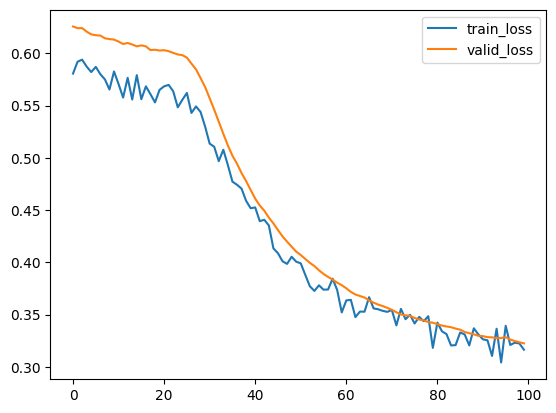

In [147]:
pd.DataFrame({
    'train_loss': [train_loss.item() for train_loss in train_losses],
    'valid_loss': [valid_loss.item() for valid_loss in valid_losses]
}).plot()

### Test

학습에서 사용한 모델의 성능 평가. <br>
train의 정확도가 높았을지라도 test의 정확도가 낮을 수 있음. <br>
&nbsp;&nbsp;&nbsp;&nbsp;이는 학습 데이터와 test 데이터가 상이함을 의미. <br>
학습 평가 시 eval() 사용. <br>
validation data와의 차이는 validation data는 학습 중에 사용되는 데이터이지만 <br>
&nbsp;&nbsp;&nbsp;&nbsp;테스트 데이터는 학습이 종료된 이후 사용되는 데이터 <br>

<br>

<font style="font-size:20px"> 사용 예제 </font> <p>

> ```python
> model.eval()                            # dropout, batch norm 등 train과 train이 아닌 경우의 동작이 다를 때 학습이 아닐 시 적용
> with torch.no_grad:                     # 가중치 업데이트를 진행하지 않기에 gradient 제거
>     for X, y in test_loader:
>         X = X.reshape(batch_size, -1).to(device)
>         y = y.to(device)
> 
>         y_pred = model(X)                
>         test_loss = criterion(y_pred, y)
> 
>         total_test_loss += test_loss
>         total_test_acc += (y == result.argmax(axis=-1)).sum()
> 
> ```

In [176]:
total_test_loss = 0 
total_test_acc = 0 

mlp.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y = y.to(device)

        logit = mlp(X)                     # calculate y_pred
        test_loss = criterion(logit, y)    # calculate loss

        predicted_label = torch.where(logit > 0.5, 1, 0)
        test_acc = (predicted_label == y).float().mean()
        total_test_loss += test_loss
        total_test_acc += test_acc

    mean_test_loss = total_test_loss / len(test_dataloader)
    mean_test_acc = total_test_acc / len(test_dataloader)

In [177]:
mean_test_acc.item()

0.859375

### Save & Load

학습된 모델의 weight를 저장 및 로드

<br>

<font style="font-size:20px"> Save </font> <p>

> ```python
> torch.save(model.state_dict(), './checkpoint/model_state_dict.pth')
> ```

<br>

<font style="font-size:20px"> Load </font> <p>

> ```python
> model = Model()
> model.load_state_dict(torch.load('./checkpoint/model_state_dict.pth'), map_location='cpu')
> ```

<br>

<font style="font-size:20px"> torch script </font> <p>

```python
scripted_model = torch.jit.script(model)

# save
scripted_model.save('./checkpoint/scripted_model.pt')

# load
loaded_model = torch.jit.load('./checkpoint/scripted_model.pt')
```

In [150]:
torch.save(mlp.state_dict(), './model/mlp.pth')

In [159]:
new_mlp = MLP(2, 4, 1)
new_mlp.load_state_dict(torch.load('./model/mlp.pth'))
new_mlp.state_dict()

In [162]:
scripted_model = torch.jit.script(mlp)
scripted_model.save('./model/scripted_model.pt')

In [164]:
loaded_scripted_model = torch.jit.load('./model/scripted_model.pt')

# Practice

## MNIST

- MNIST 데이터베이스 (Modified National Institute of Standards and Technology database)는 <br>
손으로 쓴 숫자들로 이루어진 대형 데이터베이스
- 딥러닝 예제에서 자주 사용

In [274]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if device == 'cuda':
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

# hyperprameter
batch_size = 256
epochs = 20
learning_rate = 4e-3

# data and preprocessing
train = ds.MNIST(
    root='data/mnist',
    train=True,
    transform=transforms.ToTensor(),
    download=True,
)

test = ds.MNIST(
    root='data/mnist',
    train=False,
    transform=transforms.ToTensor(),
    download=True,
)

train, valid = train_test_split(train, test_size=0.2)

class MNISTDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        X, y = self.data[idx]

        return X, y

train_dataset = MNISTDataset(train)
valid_dataset = MNISTDataset(valid)
test_dataset = MNISTDataset(test)

# data loader
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)
valid_dataloader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
)

# model
class Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
    
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.output(x)

        return x

model = Model(28*28, 256, 10).to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
for epoch in tqdm(range(1, epochs+1)):
    ###################### train ######################
    total_train_acc = 0
    total_train_loss = 0

    model.train()
    for X, y in train_dataloader:
        X = X.to(device)
        X = X.flatten(start_dim=1)
        y = y.to(device)

        optimizer.zero_grad()
        output = model(X)
        logit = F.softmax(output, dim=-1)
        train_loss = criterion(logit, y)
        train_loss.backward()
        optimizer.step()

        train_acc = (logit.argmax(dim=-1) == y).float().mean()
        total_train_acc += train_acc
        total_train_loss += train_loss
    
    mean_train_acc = total_train_acc / len(train_dataloader)
    mean_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(mean_train_loss.item())
    train_accs.append(mean_train_acc)

    ###################### valid ######################
    total_valid_acc = 0
    total_valid_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in valid_dataloader:
            X = X.to(device)
            X = X.flatten(start_dim=1)
            y = y.to(device)

            output = model(X)
            logit = F.softmax(output, dim=-1)
            valid_loss = criterion(logit, y)

            valid_acc = (logit.argmax(dim=-1) == y).float().mean()
            total_valid_acc += valid_acc
            total_valid_loss += valid_loss
        
    mean_valid_acc = total_valid_acc / len(valid_dataloader)
    mean_valid_loss = total_valid_loss / len(valid_dataloader)
    valid_losses.append(mean_valid_loss.item())
    valid_accs.append(mean_valid_acc)

    print(f'Epoch: {epoch} | train_loss: {mean_train_loss: .4f} | train_acc: {mean_train_acc*100: .2f}% | valid_loss: {mean_valid_loss: .4f} | valid_acc: {mean_valid_acc*100: .2f}%')

  5%|▌         | 1/20 [00:00<00:12,  1.47it/s]

Epoch: 1 | train_loss:  1.6072 | train_acc:  87.02% | valid_loss:  1.5341 | valid_acc:  93.06%


 10%|█         | 2/20 [00:01<00:12,  1.49it/s]

Epoch: 2 | train_loss:  1.5217 | train_acc:  94.35% | valid_loss:  1.5121 | valid_acc:  95.31%


 15%|█▌        | 3/20 [00:02<00:12,  1.37it/s]

Epoch: 3 | train_loss:  1.5054 | train_acc:  95.88% | valid_loss:  1.5036 | valid_acc:  95.97%


 20%|██        | 4/20 [00:02<00:11,  1.35it/s]

Epoch: 4 | train_loss:  1.4974 | train_acc:  96.58% | valid_loss:  1.4972 | valid_acc:  96.56%


 25%|██▌       | 5/20 [00:03<00:11,  1.35it/s]

Epoch: 5 | train_loss:  1.4908 | train_acc:  97.24% | valid_loss:  1.4993 | valid_acc:  96.41%


 30%|███       | 6/20 [00:04<00:10,  1.31it/s]

Epoch: 6 | train_loss:  1.4867 | train_acc:  97.61% | valid_loss:  1.4921 | valid_acc:  97.09%


 35%|███▌      | 7/20 [00:05<00:10,  1.28it/s]

Epoch: 7 | train_loss:  1.4837 | train_acc:  97.89% | valid_loss:  1.4958 | valid_acc:  96.64%


 40%|████      | 8/20 [00:06<00:09,  1.28it/s]

Epoch: 8 | train_loss:  1.4811 | train_acc:  98.13% | valid_loss:  1.4893 | valid_acc:  97.37%


 45%|████▌     | 9/20 [00:06<00:08,  1.27it/s]

Epoch: 9 | train_loss:  1.4784 | train_acc:  98.38% | valid_loss:  1.4887 | valid_acc:  97.36%


 50%|█████     | 10/20 [00:07<00:07,  1.27it/s]

Epoch: 10 | train_loss:  1.4781 | train_acc:  98.39% | valid_loss:  1.4877 | valid_acc:  97.49%


 55%|█████▌    | 11/20 [00:08<00:07,  1.28it/s]

Epoch: 11 | train_loss:  1.4757 | train_acc:  98.64% | valid_loss:  1.4868 | valid_acc:  97.53%


 60%|██████    | 12/20 [00:09<00:06,  1.27it/s]

Epoch: 12 | train_loss:  1.4757 | train_acc:  98.62% | valid_loss:  1.4867 | valid_acc:  97.54%


 65%|██████▌   | 13/20 [00:10<00:05,  1.26it/s]

Epoch: 13 | train_loss:  1.4740 | train_acc:  98.80% | valid_loss:  1.4889 | valid_acc:  97.24%


 70%|███████   | 14/20 [00:10<00:04,  1.25it/s]

Epoch: 14 | train_loss:  1.4738 | train_acc:  98.80% | valid_loss:  1.4883 | valid_acc:  97.35%


 75%|███████▌  | 15/20 [00:11<00:04,  1.23it/s]

Epoch: 15 | train_loss:  1.4734 | train_acc:  98.84% | valid_loss:  1.4880 | valid_acc:  97.31%


 80%|████████  | 16/20 [00:12<00:03,  1.22it/s]

Epoch: 16 | train_loss:  1.4721 | train_acc:  98.94% | valid_loss:  1.4856 | valid_acc:  97.62%


 85%|████████▌ | 17/20 [00:13<00:02,  1.19it/s]

Epoch: 17 | train_loss:  1.4712 | train_acc:  99.06% | valid_loss:  1.4847 | valid_acc:  97.69%


 90%|█████████ | 18/20 [00:14<00:01,  1.18it/s]

Epoch: 18 | train_loss:  1.4715 | train_acc:  99.00% | valid_loss:  1.4873 | valid_acc:  97.44%


 95%|█████████▌| 19/20 [00:15<00:00,  1.16it/s]

Epoch: 19 | train_loss:  1.4704 | train_acc:  99.11% | valid_loss:  1.4842 | valid_acc:  97.72%


100%|██████████| 20/20 [00:16<00:00,  1.25it/s]

Epoch: 20 | train_loss:  1.4698 | train_acc:  99.18% | valid_loss:  1.4859 | valid_acc:  97.48%


In [276]:
torch.save(model.state_dict(), './model/mnist.pth')
model = Model(28*28, 256, 10)
model.load_state_dict(torch.load('./model/mnist.pth'))

C:\Users\USER\AppData\Local\Temp\ipykernel_19628\1641817439.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./model/mnist.pth'))


<All keys matched successfully>

In [278]:
total_test_acc = 0
total_test_loss = 0

model.eval()
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        X = X.flatten(start_dim=1)
        y = y.to(device)

        output = model(X)
        logit = F.softmax(output, dim=-1)
        test_loss = criterion(logit, y)

        test_acc = (logit.argmax(dim=-1) == y).float().mean()
        total_test_acc += test_acc
        total_test_loss += test_loss
    
mean_test_acc = total_test_acc / len(test_dataloader)
print(mean_test_acc.item())

0.9778645634651184
